<a href="https://colab.research.google.com/github/ishwarraja/SOAI-ERAV2/blob/main/S10/S10_22Jul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1
import torch
import cv2
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import OneCycleLR
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
from torch.utils.data import DataLoader, random_split
import numpy as np

In [2]:

# STEP 2
# Define the transformation to apply to the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.4), ratio=(0.3, 3.3)),
    transforms.RandomCrop(32, padding=8),  # Add CutOut after RandomErasing
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download and load the CIFAR10 training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Create data loaders for training, validation, and test set
trainloader = DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=512, shuffle=False, num_workers=2)

# Download and load the CIFAR10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:13<00:00, 13011497.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# STEP 3
# Define the transformation to apply to the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image tensor
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.4), ratio=(0.3, 3.3))  # Randomly erase a rectangle in the image
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the CIFAR10 training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

# Download and load the CIFAR10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


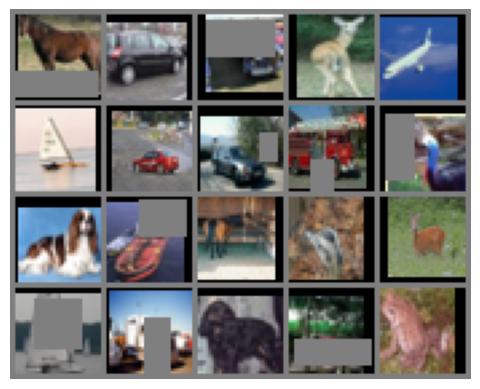

In [4]:
# STEP 4 Choose Random Image
# Select a sample of 20 images from the training set
sample_indices = torch.randint(low=0, high=len(trainset), size=(20,))
sample_images = [trainset[i][0] for i in sample_indices]

# Create a grid of images
grid_image = torchvision.utils.make_grid(sample_images, nrow=5, padding=2)

# Unnormalize the grid_image tensor
grid_image = grid_image / 2 + 0.5

# Convert the tensor to numpy array
grid_image = grid_image.numpy().transpose((1, 2, 0))

# Display the grid of images
plt.imshow(grid_image)
plt.axis('off')
plt.show()

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


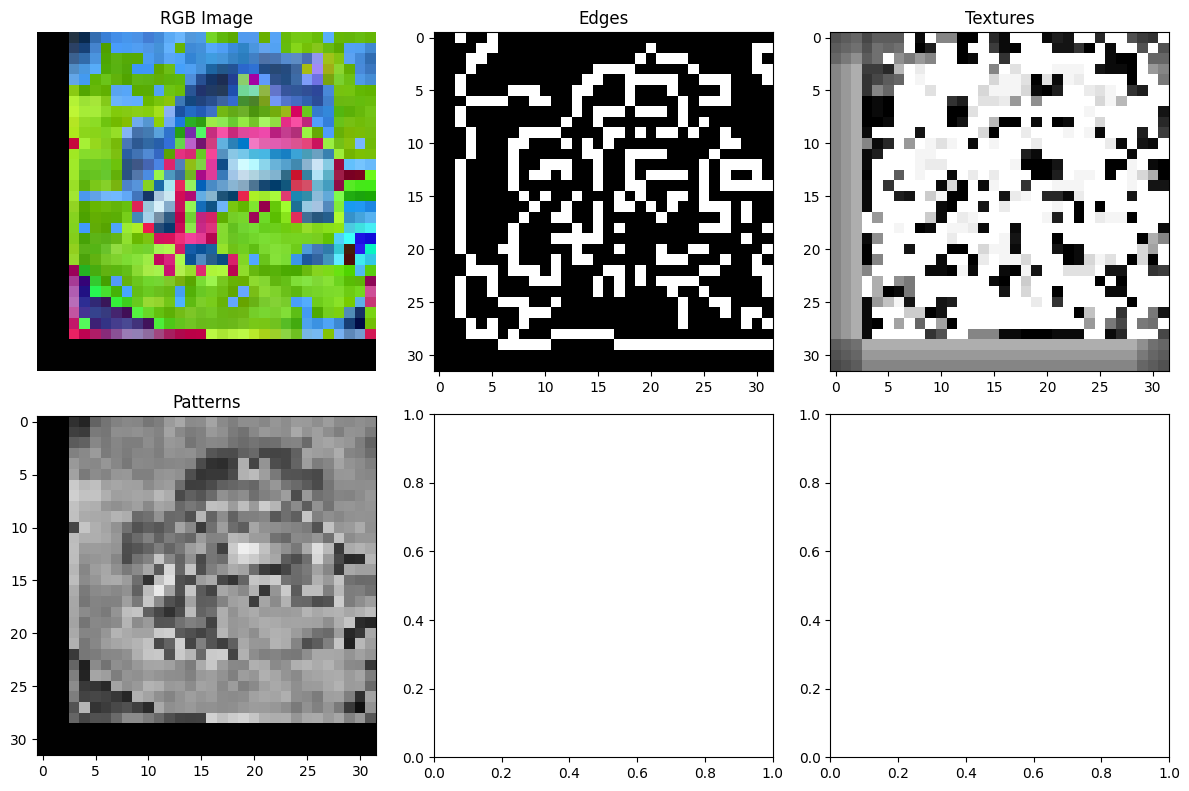

In [5]:
# STEP 5 Choose Image For Training
# Select an image from the training set
image_index = 0  # Change this to the desired image index
image, label = trainset[image_index]

# # Convert the tensor image to a PIL image
# pil_image = TF.to_pil_image(image)

# # Display the PIL image
# pil_image.show()

# Convert the image tensor to a numpy array and transpose the dimensions
image = image.numpy().transpose((1, 2, 0))

# Convert the image to RGB format
image_rgb = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_BGR2RGB)

# Apply edge detection using Canny edge detection algorithm
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(image_gray, threshold1=100, threshold2=200)

# Apply unsharp masking to enhance details
blur = cv2.GaussianBlur(image_gray, (0, 0), sigmaX=2)
sharp = cv2.addWeighted(image_gray, 1.5, blur, -0.5, 0)

# Apply texture analysis using Local Binary Patterns (LBP)
radius = 3
n_points = 8 * radius
lbp = local_binary_pattern(image_gray, n_points, radius, method='uniform')

# Apply contrast stretching to enhance the image's dynamic range
min_val = np.min(sharp)
max_val = np.max(sharp)
stretch = cv2.convertScaleAbs(sharp, alpha=255.0/(max_val-min_val), beta=-min_val * 255.0 / (max_val-min_val))

# Perform pattern detection using Oriented FAST and Rotated BRIEF (ORB)
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(image_gray, None)

# Compute gray-level co-occurrence matrix for texture analysis
image_texture = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
co_matrix = greycomatrix(image_texture, distances=[1], angles=[0], symmetric=True, normed=True)
contrast = greycoprops(co_matrix, prop='contrast')[0, 0]
dissimilarity = greycoprops(co_matrix, prop='dissimilarity')[0, 0]
homogeneity = greycoprops(co_matrix, prop='homogeneity')[0, 0]

# Display the original image, edges, textures, patterns, and detected objects
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].imshow(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original Image')

axes[0, 1].imshow(edges, cmap='gray')
axes[0, 1].set_title('Edges')

axes[0, 2].imshow(lbp, cmap='gray')
axes[0, 2].set_title('Textures')

axes[1, 0].imshow(cv2.drawKeypoints(image_gray, keypoints, None))
axes[1, 0].set_title('Patterns')

axes[0, 0].imshow(image_rgb)
axes[0, 0].set_title('RGB Image')
axes[0, 0].axis('off')

plt.tight_layout()
plt.show()


In [6]:

# STEP 6 Using Resnet Architecture
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return x + self.residual(x)

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.prep_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResBlock(128, 128)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            ResBlock(512, 512)
        )

        self.maxpool = nn.MaxPool2d(kernel_size=4)

        self.fc = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.prep_layer(x)
        x = self.layer1(x)
        x = x + self.layer1[3](x)  # Skip connection
        x = self.layer2(x)
        x = self.layer3(x)
        x = x + self.layer3[4](x)  # Skip connection
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

# Creating an instance of the CustomResNet model
model = CustomResNet()


In [7]:

#STEP 7
# Using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Count the number of trainable parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")





Total Trainable Parameters: 6575370


In [8]:
# STEP 8

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [12]:
# STEP 9
# Define the One Cycle Policy learning rate scheduler
max_lr = 0.001  # Maximum learning rate (tune this as needed)
total_epochs = 24
max_at_epoch = 5
steps_up = max_at_epoch * len(trainloader)
steps_down = (total_epochs - max_at_epoch) * len(trainloader)

# Calculate LRMIN
lr_min_factor = 0.1
lr_min = lr_min_factor * max_lr

# Define the One Cycle LR scheduler
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=steps_up + steps_down,epochs=max_at_epoch, steps_per_epoch=len(trainloader), anneal_strategy='cos')

In [13]:

# STEP 8
# Training the model
num_epochs = 24
target_accuracy = 90.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step()  # Step the One Cycle LR scheduler

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation after each epoch
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total * 100
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # # Early stopping based on validation accuracy
    # if val_accuracy >= target_accuracy:
    #     print("Target accuracy reached. Training stopped.")
    #     break

# Evaluate on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/24], Loss: 2.0495
Validation Accuracy: 37.74%
Epoch [2/24], Loss: 2.0323
Validation Accuracy: 39.59%
Epoch [3/24], Loss: 2.0201
Validation Accuracy: 40.18%
Epoch [4/24], Loss: 2.0153
Validation Accuracy: 40.16%
Epoch [5/24], Loss: 2.0133
Validation Accuracy: 40.89%
Epoch [6/24], Loss: 2.0142
Validation Accuracy: 39.53%
Epoch [7/24], Loss: 2.0129
Validation Accuracy: 41.79%
Epoch [8/24], Loss: 2.0055
Validation Accuracy: 41.38%
Epoch [9/24], Loss: 2.0004
Validation Accuracy: 43.03%
Epoch [10/24], Loss: 1.9931
Validation Accuracy: 40.03%
Epoch [11/24], Loss: 1.9856
Validation Accuracy: 42.89%
Epoch [12/24], Loss: 1.9848
Validation Accuracy: 41.84%
Epoch [13/24], Loss: 1.9728
Validation Accuracy: 44.00%
Epoch [14/24], Loss: 1.9717
Validation Accuracy: 44.22%
Epoch [15/24], Loss: 1.9656
Validation Accuracy: 45.57%
Epoch [16/24], Loss: 1.9611
Validation Accuracy: 45.75%
Epoch [17/24], Loss: 1.9563
Validation Accuracy: 46.14%
Epoch [18/24], Loss: 1.9520
Validation Accuracy: 47.07%
E